<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/ccm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCM & PAI

**Convergent Cross Mapping & Pairwise Asymmetric Inference**

*Authors: Cátia Fortunato & Alexander Del Toro Barba*

**Data Set**

https://webdav.tuebingen.mpg.de/cause-effect/

Choose one data set where correlation is low, one where is high

**Next Steps**

* Alex: read PAI paper
* Choose data sets
* Cátia: Code for CCM in Colab



In [ ]:
# Import packages
import numpy as np
import sklearn
from decimal import *
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convergent Cross Mapping

## Code

In [ ]:
## Code for CCM 
def compute_corr(y_pred, y_target):
    corr=np.corrcoef(y_pred,y_target)[1,0]
    return corr

def build_shadow_manifold(X,tau,E,T):
  '''Build the shadow manifold of the time series signal X, with dimension E and lag time tau'''
  shadow_M=np.zeros((len(X[(E-1)*tau:]),E))
  for i in range(E):
    shadow_M[:,i]=X[(E-i-1)*tau:len(X)-i*tau]
  return shadow_M

def sample_manifold(M,L):
  '''Randomly select L points from the shadow manifold M'''
  new_M=np.zeros((L,M.shape[1]))
  idx=np.random.randint(M.shape[0],size=L)
  new_M=M[idx,:]
  return new_M, idx

def nearest_points(shadow_m,recon_shadow_m,idx,E):
  '''Find the nearest neighbours in the '''
  distances=np.zeros((shadow_m.shape[0],recon_shadow_m.shape[0]+1))
  distances[:,0]=np.array(range(0,shadow_m.shape[0]))
  dist_matrix=np.zeros((shadow_m.shape[0],E+1))
  indices=np.zeros((shadow_m.shape[0],E+1)) # the first column is the index

  for i in range(shadow_m.shape[0]): # for each point in the manifold
    distances[i,1:]=LA.norm(shadow_m[i,:]-recon_shadow_m,axis=1) #distance between the point and all the points in the library
    vec=distances[i,1:]
    for j in range(E+1):
      min_val=np.min(vec)
      idx_i=np.where(vec==min_val)[0]
      if idx_i[0]==np.int(distances[i,0]):
        vec[idx_i]=1000
        min_val=np.min(vec)
        idx_i=np.where(vec==min_val)[0]
      vec[idx_i]=1000
      distances[i,j]=min_val
      indices[i,j]=idx[idx_i[0]]
  return distances, indices

def compute_weights(shadow,distances,indices,T,E,eps=0.00001):
  '''Compute the weights based on the simplex projection and exponential decay'''
    weights=np.zeros((len(shadow),E+1))
    weights_u=np.zeros((len(shadow),E+1))
    MY_pred=np.zeros((len(shadow),E))
    for i in range (len(shadow)):
        for j in range(0,E+1):
            num=(distances[i,j])
            den=(eps+distances[i,1])
            weights_u[i,j-1]=np.exp(-(num)/(den))
        if np.isinf(np.sum(weights[i,:])):
            weights[i,0]=1
        else:
            weights[i,:]=weights_u[i,:]/np.sum(weights_u[i,:])
        MY_pred[i,:]=np.dot(weights[i,:],(list(shadow[np.int(j),:] for j in indices[i,:])))
    return weights, MY_pred

def compute_xmap(X,Y,T,E,tau,L):
    '''Compute the convergent cross mapping between X and Y'''
    
    # Build the shadow manifold 
    shadow_x=build_shadow_manifold(X,tau,E,T)
    shadow_y=build_shadow_manifold(Y,tau,E,T)
    
    
    # Select randomly L points from the shadow manifold 
    recon_Mx, idx_x=sample_manifold(shadow_x,L)
    recon_My, idx_y=sample_manifold(shadow_y,L)  
    
    ########## Predict Y from X ##########################

    
    # find nearest neighbors

    distances_x, indices_x=nearest_points(shadow_x,recon_Mx,idx_x,E)

    # compute weights
    weights_w_x, My_pred=compute_weights(shadow_y,distances_x,indices_x,T,E)
    y_pred=My_pred[:,0]
    y_target=shadow_y[:,0]

    
    ########## Predict X from Y ##########################

    # find nearest neighbors

    distances_y, indices_y=nearest_points(shadow_y, recon_My,idx_y,E)

    
    # compute weights
    weights_w_y, Mx_pred=compute_weights(shadow_x,distances_y,indices_y,T,E)
    x_pred=Mx_pred[:,0]
    x_target=shadow_x[:,0]

    return y_pred, y_target, x_pred, x_target

def example(X,Y,T,tau,E,L,emsemble):
    rhox=np.zeros((len(L),emsemble))
    rhoy=np.zeros((len(L),emsemble))
    for i in range(len(L)):
        for j in range (emsemble):
            
            y_pred, y_target, x_pred, x_target = compute_xmap(X,Y,T,E,tau,L[i])
            rhox[i,j]=compute_corr(y_pred,y_target)
            rhoy[i,j]=compute_corr(x_pred,x_target)

    rhox_mean=np.mean(rhox,1)
    rhoy_mean=np.mean(rhoy,1)
    rhox_std=np.std(rhox,1)
    rhoy_std=np.std(rhoy,1)
    return rhox_mean,rhoy_mean,rhox_std,rhoy_std,L 


## Ephemeral regimes in a coupled dynamic system

Considering the example of a non linear chaotic model that follows the two sets of equations:

 $X(t+1)=X(t)[r_x - r_xX(t)-\beta_{x,y}Y(t)]$

 $Y(t+1)=Y(t)[r_y - r_yY(t)-\beta_{y,x}X(t)]$

 The first example we set $\beta_{x,y}$ to be 0.02 and $\beta_{y,x}$ to be 0.1. In this context the value chosen for $\beta_{x,y}$ will describe how much $Y$ influences $X$. And, as a consequence,  $\beta_{y,x}$ reflects how much $X$ influences $Y$. Given that $\beta_{x,y}$ is greater than $\beta_{y,x}$, $X$ will influence $Y$ more than the other way around. 

In [ ]:
T=8000
rx=3.8
ry=3.5
betaxy=0.02
betayx=0.1

x=np.zeros((T))
y=np.zeros((T))
x[0]=0.2
y[0]=0.4

for i in range(T-1):
    x[i+1]=x[i]*(rx-rx*x[i]-betaxy*y[i])
    y[i+1]=y[i]*(ry-ry*y[i]-betayx*x[i])

In [ ]:
E=3
tau=1
L=list(range(E+1,3000,200))
emsemble=10
rhox_mean,rhoy_mean,rhox_std,rhoy_std,L = example(x,y,T,tau,E,L,emsemble)

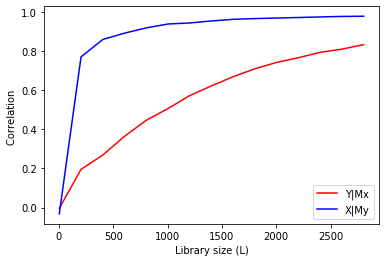

In [ ]:
fig2=plt.figure()
ax2=fig2.add_subplot(111)
ax2.plot(L,rhox_mean,'red')
ax2.plot(L,rhoy_mean,'blue')
ax2.set_xlabel('Library size (L)')
ax2.set_ylabel('Correlation ')
plt.legend(('Y|Mx','X|My'))

Since $X$ is influencing $Y$ more than the other way around, the convergence of $X|M_y$ will be faster than that of $Y|M_x$.

Let's now consider the case of unidirectional causality. To simulate this model, we will be considering the same set of equations previously used but we are going to set one of the values of $\beta$ to be 0. 

In [ ]:
T=8000
rx=3.8
ry=3.5
betaxy=0
betayx=0.1

x=np.zeros((T))
y=np.zeros((T))
x[0]=0.2
y[0]=0.4

for i in range(T-1):
    x[i+1]=x[i]*(rx-rx*x[i]-betaxy*y[i])
    y[i+1]=y[i]*(ry-ry*y[i]-betayx*x[i])

In [ ]:
E=3
tau=1
L=list(range(E+1,3000,200))
emsemble=10
rhox_mean,rhoy_mean,rhox_std,rhoy_std,L = example(x,y,T,tau,E,L,emsemble)

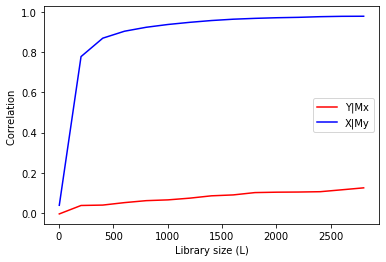

In [ ]:
fig2=plt.figure()
ax2=fig2.add_subplot(111)
ax2.plot(L,rhox_mean,'red')
ax2.plot(L,rhoy_mean,'blue')
ax2.set_xlabel('Library size (L)')
ax2.set_ylabel('Correlation ')
plt.legend(('Y|Mx','X|My'))

In this case since we set  $\beta_{x,y}$  to zero, $Y$ has no influence on $X$ therefore, when we try to use $X$ to predict $Y$ the plot does not converge to 1. From these two results it is possible to see that the model clearly distinguishes between bidirectional and unidirectional causality. 

# Pairwise Assymetric Inference

They use squared pearson correlation instead of the unsquared like the original CCM paper. I believe this is because here they are subtracting values of correlation and is to prevent cases of subtracting negative numbers and give the wrong sense of causality. 

They construct the shadow manifold in a different way where each point in the manifold is described as follows:

$X'_t=(X_t,X_{t-\tau},X_{t-2\tau},...,Y_t)$

They then use the weights of this new manifold to estimate the values of X. 


#Code

In [ ]:
def compute_corr_pai(y_pred, y_target):
    corr=np.corrcoef(y_pred,y_target)[1,0]
    corr=corr**2
    return corr

def compute_manifold_pai(X,Y,tau,E):
  shadow_M=np.zeros((len(X[(E-1)*tau:]),E+1))
  for i in range(E):
    shadow_M[:,i]=X[(E-i-1)*tau:len(X)-i*tau]
  shadow_M[:,E]=Y[(E-1)*tau:len(Y)]
  return shadow_M

def compute_weights_pai(shadow,distances,indices,T,E,eps=0.00001):
  #'''Compute the weights based on the simplex projection and exponential decay'''
    weights=np.zeros(indices.shape)
    weights_u=np.zeros(indices.shape)
    MY_pred=np.zeros((len(shadow),E))
    for i in range (len(shadow)):
        for j in range(0,indices.shape[1]):
            num=(distances[i,j])
            den=(eps+distances[i,1])
            weights_u[i,j-1]=np.exp(-(num)/(den))
        if np.isinf(np.sum(weights[i,:])):
            weights[i,0]=1
        else:
            weights[i,:]=weights_u[i,:]/np.sum(weights_u[i,:])
        MY_pred[i,:]=np.dot(weights[i,:],(list(shadow[np.int(j),:] for j in indices[i,:])))
    return weights, MY_pred

def compute_pai(X,Y,T,E,tau,L):

  # Use YX to predict Y ############################

  manifold_YX = compute_manifold_pai(Y,X,tau,E)
  manifold_Y = build_shadow_manifold(Y,tau,E,T)

  recon_manifold_YX, idx_y=sample_manifold(manifold_YX,L)

  distances_y, indices_y=nearest_points(manifold_YX,recon_manifold_YX,idx_y,E+1)

  weights_w_y, My_pred=compute_weights_pai(manifold_Y,distances_y,indices_y,T,E)
  y_pred=My_pred[:,0]
  y_target=manifold_Y[:,0]

  # Use XY to predict X ############################

  manifold_XY = compute_manifold_pai(X,Y,tau,E)
  manifold_X = build_shadow_manifold(X,tau,E,T)

  recon_manifold_XY, idx_x=sample_manifold(manifold_XY,L)

  distances_x, indices_x=nearest_points(manifold_XY,recon_manifold_XY,idx_x,E+1)

  weights_w_x, Mx_pred=compute_weights_pai(manifold_X,distances_x,indices_x,T,E)
  x_pred=Mx_pred[:,0]
  x_target=manifold_X[:,0]

  return y_pred, y_target, x_pred, x_target

def run_pai(X,Y,T,tau,E,L,emsemble):
  C_X_XY=np.zeros((len(L),emsemble))
  C_Y_YX=np.zeros((len(L),emsemble))
  for i in range(len(L)):
    for j in range(emsemble):
      #print("L ="+str(i)+" and emsemble ="+str(j))
      y_pred, y_target, x_pred, x_target = compute_pai(X,Y,T,E,tau,L[i])
      C_Y_YX[i,j]=compute_corr_pai(y_pred,y_target)
      C_X_XY[i,j]=compute_corr_pai(x_pred,x_target)
  rhox_mean=np.mean(C_X_XY,1)
  rhoy_mean=np.mean(C_Y_YX,1)
  rhox_std=np.std(C_X_XY,1)
  rhoy_std=np.std(C_Y_YX,1)
  delta=rhox_mean-rhoy_mean
  return rhox_mean,rhoy_mean,rhox_std,rhoy_std,L,delta 



## Test PAI


Test when X is causing Y, but Y is **not** cuasing X.

In [ ]:
T=8000
rx=3.8
ry=3.5
betaxy=0
betayx=0.1

x=np.zeros((T))
y=np.zeros((T))
x[0]=0.2
y[0]=0.4

for i in range(T-1):
    x[i+1]=x[i]*(rx-rx*x[i]-betaxy*y[i])
    y[i+1]=y[i]*(ry-ry*y[i]-betayx*x[i])

In [ ]:
E=3
tau=1
L=list(range(E+2,3000,200))
emsemble=10
rhox_mean,rhoy_mean,rhox_std,rhoy_std,L,delta = run_pai(x,y,T,tau,E,L,emsemble)

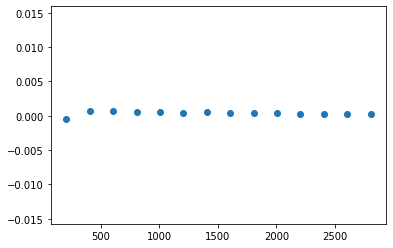

In [ ]:
plt.scatter(L[1:], delta[1:])

In [ ]:
delta 

array([-2.48426726e-01, -4.91172167e-04,  7.08404421e-04,  6.47909949e-04,
        6.16968601e-04,  5.97791288e-04,  4.80684331e-04,  4.94509308e-04,
        4.21745681e-04,  3.56037038e-04,  3.53922690e-04,  3.35719868e-04,
        2.95643589e-04,  2.76090793e-04,  2.45922668e-04])

Test when Y is causing X, but X is **not** causing Y.

In [ ]:
T=8000
rx=3.8
ry=3.5
betaxy=0.1
betayx=0

x=np.zeros((T))
y=np.zeros((T))
x[0]=0.2
y[0]=0.4

for i in range(T-1):
    x[i+1]=x[i]*(rx-rx*x[i]-betaxy*y[i])
    y[i+1]=y[i]*(ry-ry*y[i]-betayx*x[i])

In [ ]:
E=3
tau=1
L=list(range(E+2,3000,200))
emsemble=10
rhox_mean,rhoy_mean,rhox_std,rhoy_std,L,delta = run_pai(x,y,T,tau,E,L,emsemble)

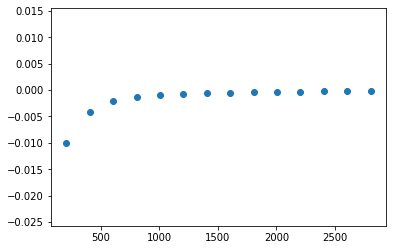

In [ ]:
plt.scatter(L[1:], delta[1:])

In [ ]:
delta 

array([-2.58855199e-01, -1.00333833e-02, -4.20972606e-03, -2.15205010e-03,
       -1.35944978e-03, -8.84121387e-04, -7.51935224e-04, -6.41912309e-04,
       -5.42233343e-04, -4.19840156e-04, -4.06986958e-04, -2.88959563e-04,
       -2.73575077e-04, -2.06207516e-04, -2.12120421e-04])

Test when both X and Y are causing eachother, but one has a stronger impact. 

In [ ]:
T=8000
rx=3.8
ry=3.5
betaxy=0.02
betayx=0.1

x=np.zeros((T))
y=np.zeros((T))
x[0]=0.2
y[0]=0.4

for i in range(T-1):
    x[i+1]=x[i]*(rx-rx*x[i]-betaxy*y[i])
    y[i+1]=y[i]*(ry-ry*y[i]-betayx*x[i])

In [ ]:
E=3
tau=1
L=list(range(E+2,3000,200))
emsemble=10
rhox_mean,rhoy_mean,rhox_std,rhoy_std,L,delta = run_pai(x,y,T,tau,E,L,emsemble)

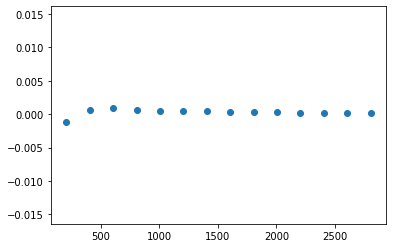

In [ ]:
plt.scatter(L[1:], delta[1:])

In [ ]:
delta 

array([-2.24490728e-01, -1.12388726e-03,  6.25977853e-04,  8.51563607e-04,
        6.95326049e-04,  5.46260750e-04,  4.81318152e-04,  4.19743329e-04,
        3.55749875e-04,  3.02462944e-04,  2.79601835e-04,  2.37007864e-04,
        2.30527883e-04,  2.02701549e-04,  1.91995554e-04])

From this test we can see than, as proposed in the paper, this method is able to identify which variable is the driver in the case of unidirectional causality. When tested for bidirectional causality, and one of the variables is stronger, the method identifies the varible that has a stronger effect. 
